# Goal
Make an AI model that can predict the challenge rating (CR) of a monster from Dungeons and Dragons (D&D).

Data was previously collected using the [DataCollection](https://github.com/velzenor/DnDMonsterClassifier/blob/538f8304157d706431e0afc53846e3894aed0b35/DataCollection.ipynb) notebook from this same project.

In [6]:
%%bash
curl https://raw.githubusercontent.com/velzenor/DnDMonsterClassifier/refs/heads/main/monsters.csv > monsters.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54647  100 54647    0     0   135k      0 --:--:-- --:--:-- --:--:--  135k


In [7]:
import pandas as pd
data = pd.read_csv('monsters.csv')
data.head(3)

,Name,SizeType,Align,AC,Init,HP,Multiattack,LegRes,LegAct,Speed,CR,PB,Str,Dex,Con,Int,Wis,Cha
0,Aboleth,Large Aberration,Lawful Evil,17,+7 (17),150 (20d10 + 40),True,True,True,"10 ft., Swim 40 ft.",10,4,21/+5/+5,9/−1/+3,15/+2/+6,18/+4/+8,15/+2/+6,18/+4/+4
1,Air Elemental,Large Elemental,Neutral,15,+5 (15),90 (12d10 + 24),True,False,False,"10 ft., Fly 90 ft. (hover)",5,3,14/+2/+2,20/+5/+5,14/+2/+2,6/−2/−2,10/+0/+0,6/−2/−2
2,Animated Armor,Medium Construct,Unaligned,18,+2 (12),33 (6d8 + 6),True,False,False,25 ft.,1,2,14/+2/+2,11/+0/+0,13/+1/+1,1/−5/−5,3/−4/−4,1/−5/−5


# Cleaning
Cleaning tasks to perform:
- convert numerical values into float or int.
- explode the score columns
- add tier as a new derivative feature
- explode the SizeType column?
- ...


In [90]:
from fractions import Fraction
import numpy as np

def clean(data:pd.DataFrame):
  data = data.copy()

  #clean and convert integer features
  data['Init'] = data['Init'].map(lambda e: e.split('(')[0].replace('−','-')).astype(pd.Int16Dtype())
  _ = data['HP'].map(lambda e: e.split('(')[1].split('d')[0]).astype(pd.Int16Dtype())
  data.insert(data.columns.get_loc('HP')+1,'HitDice',_)
  data['HP'] = data['HP'].map(lambda e: e.split('(')[0]).astype(pd.Int16Dtype())
  for col in ['AC','PB']:
    data[col] = data[col].astype(pd.Int16Dtype())

  #convert CR to float (some monsters have fractional CR, ex. 1/4 or 1/2)
  data['CR'] = data['CR'].map(lambda e: Fraction(e)).astype(pd.Float32Dtype())

  #convert Speed into a boolean for whether the monster can fly
  _ = data['Speed'].map(lambda e: 'fly' in e.lower())
  data.insert(data.columns.get_loc('Speed')+1,'Flying',_)

  #restructure the scores data
  scores = ['Str','Dex','Con','Int','Wis','Cha']
  _ = pd.DataFrame()
  for col in scores:
    _[[col,col+'Mod',col+'Save']] = data[col].str.split('/',expand=True)
  for col in _.columns:
    _[col] = _[col].str.replace('−','-').astype(pd.Int16Dtype()) #fix type
  data = data.drop(columns=scores)
  data = data.join(_)

  return data

data_clean = clean(data)
print(data_clean.columns)
data_clean.head(3)

Index(['Name', 'SizeType', 'Align', 'AC', 'Init', 'HP', 'HitDice',
       'Multiattack', 'LegRes', 'LegAct', 'Speed', 'Flying', 'CR', 'PB', 'Str',
       'StrMod', 'StrSave', 'Dex', 'DexMod', 'DexSave', 'Con', 'ConMod',
       'ConSave', 'Int', 'IntMod', 'IntSave', 'Wis', 'WisMod', 'WisSave',
       'Cha', 'ChaMod', 'ChaSave'],
      dtype='object')


,Name,SizeType,Align,AC,Init,HP,HitDice,Multiattack,LegRes,LegAct,...,ConSave,Int,IntMod,IntSave,Wis,WisMod,WisSave,Cha,ChaMod,ChaSave
0,Aboleth,Large Aberration,Lawful Evil,17,7,150,20,True,True,True,...,6,18,4,8,15,2,6,18,4,4
1,Air Elemental,Large Elemental,Neutral,15,5,90,12,True,False,False,...,2,6,-2,-2,10,0,0,6,-2,-2
2,Animated Armor,Medium Construct,Unaligned,18,2,33,6,True,False,False,...,1,1,-5,-5,3,-4,-4,1,-5,-5


# Preprocessing
- remove features that the model won't use, either because non-numeric or other reasons (see below)
- split data into train and test
- encode any class features (using none currently)

Note: To make this project a proper challenge, certain features which are already known to be derived from CR will be purposely omitted form the data, namely PB and all of the 'saves'.

In [92]:
from sklearn.model_selection import train_test_split

#note purposely omitting PB and the saves
#score mods are also omitted since derived directly from the scores
features = ['AC', 'Init', 'HP', 'HitDice','Multiattack', 'LegRes', 'LegAct',  'Flying', 'CR', \
            'Str', 'Dex', 'Con', 'Int', 'Wis', 'Cha']

_ = data_clean[features]
data_train,data_test = train_test_split(_,test_size=0.25)

data_train.head(3)

,AC,Init,HP,HitDice,Multiattack,LegRes,LegAct,Flying,CR,Str,Dex,Con,Int,Wis,Cha
7,9,-1,10,3,False,False,False,False,0.0,3,8,11,10,10,6
277,15,1,52,7,True,False,False,False,3.0,16,13,15,1,9,3
131,17,7,170,31,True,False,False,False,12.0,10,14,12,20,15,16


# EDA
Look at the correlations for the features

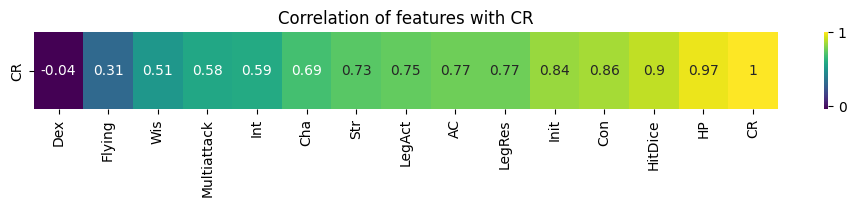

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

_ = data_train.corr()['CR'].sort_values(ascending=True)
_ = pd.DataFrame(_).T.round(2)
plt.figure(figsize=(12,1))
plt.title('Correlation of features with CR')
sns.heatmap(_,cmap='viridis',annot=True)
plt.show()

# Training and Scoring
Use a Random Forest model

In [94]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=500)
X = data_train.drop(columns='CR')
y = data_train['CR']
model.fit(X,y)

#accuracy with test dataset
model.score(data_test.drop(columns='CR'),data_test['CR'])

0.9723638658462392

In [100]:
#view sample of the test dataset predictions
cr_estimates = model.predict(data_test.drop(columns='CR').sort_index())
_ = data_clean[['Name','SizeType','Align','Speed']].join(data_test.sort_index(),how='inner')
_.insert(0,'CREst',cr_estimates)
_.insert(1,'CR',_.pop('CR'))
_.sample(4)

,CREst,CR,Name,SizeType,Align,Speed,AC,Init,HP,HitDice,Multiattack,LegRes,LegAct,Flying,Str,Dex,Con,Int,Wis,Cha
13,2.758,2.0,Bandit Captain,Medium or Small Humanoid,Neutral,30 ft.,15,3,52,8,True,False,False,False,15,16,14,14,11,14
310,2.075,2.0,Rhinoceros,Large Beast,Unaligned,40 ft.,13,-1,45,6,False,False,False,False,21,8,15,2,12,6
327,0.434,0.5,Warhorse,Large Beast,Unaligned,60 ft.,11,1,19,3,False,False,False,False,18,12,13,2,12,7
40,4.918,5.0,Bulette,Large Monstrosity,Unaligned,"40 ft., Burrow 40 ft.",17,0,94,9,True,False,False,False,19,11,21,2,10,5


In [122]:
#test with custom inputs
custom_monster = {'AC':16, 'Init':5, 'HP':100, 'HitDice':10, 'Multiattack':True, 'LegRes':False, 'LegAct':False, \
       'Flying':True, 'Str':10, 'Dex':10, 'Con':10, 'Int':10, 'Wis':10, 'Cha':11}
_ = round(model.predict(pd.DataFrame([custom_monster]))[0])
print(f"Such a monster's CR would likely be ~{_}.")

Such a monster's CR would likely be ~6.


In [137]:
#now put in pickle, make a third notebook or script that let's people input custom monsters (as a demo)
#try knn???